<a href="https://colab.research.google.com/github/thdefn/AIproj2022/blob/master/1202_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

from tensorflow import keras

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization 
from tensorflow.keras.utils import to_categorical

In [2]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

import seaborn as sns
import os
import glob
import plotly.graph_objects as go
import cv2
from PIL import Image
from PIL import ImageFile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop,Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")
ImageFile.LOAD_TRUNCATED_IMAGES = True

from tqdm import tqdm

In [3]:
import os
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
cd /content/gdrive/My Drive/data/.kaggle

/content/gdrive/My Drive/data/.kaggle


In [5]:
X_valid = np.load('./X_valid_128.npy',allow_pickle=True)
y_valid = np.load('./y_valid_128.npy',allow_pickle=True)
X_train = np.load('./X_train_128.npy',allow_pickle=True)
y_train = np.load('./y_train_128.npy',allow_pickle=True)
X_test = np.load('./X_test_128.npy',allow_pickle=True)
y_test = np.load('./y_test_128.npy',allow_pickle=True)


X_train = X_train/255
X_valid = X_valid/255
X_test = X_test/255

le = LabelEncoder().fit(['Type 1', 'Type 2', 'Type 3'])
y_train = le.transform(y_train)
y_valid = le.transform(y_valid)

y_train_onehot = to_categorical(y_train, num_classes=3)
y_valid_onehot = to_categorical(y_valid, num_classes=3)

In [ ]:
BATCH_SIZE = 16
TRAIN_STEPS = len(X_train)//BATCH_SIZE
VAL_STEPS = len(X_valid)//BATCH_SIZE
t = ImageDataGenerator(rotation_range=0.3, zoom_range=0.3)
k = ImageDataGenerator()
valid_gen = t.flow(X_valid, y_valid_onehot, batch_size = BATCH_SIZE)
train_gen = t.flow(X_train, y_train_onehot, batch_size = BATCH_SIZE)
valid_ngen = k.flow(X_valid, y_valid_onehot, batch_size = BATCH_SIZE)
train_ngen = k.flow(X_train, y_train_onehot, batch_size = BATCH_SIZE)

## 일반 CNN

In [ ]:
reduceLR = ReduceLROnPlateau(monitor='val_accuracy', patience=10, verbose= 1, mode='max', factor=  0.2, min_lr = 1e-5)

early_stopping = EarlyStopping(monitor='val_accuracy', patience = 20, verbose=1, mode='max', restore_best_weights= True)

checkpoint_ag = ModelCheckpoint('cnn_v2_ag.weights.hdf5', monitor='val_accuracy', verbose=1,save_best_only=True, mode= 'max')

In [ ]:
cnn = Sequential([
    Conv2D(64, kernel_size = (3,3), padding='same', kernel_initializer='random_normal', 
           input_shape=(128,128,3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),
    
    Conv2D(32, kernel_size = (3,3), padding='same', kernel_initializer='random_normal'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),
    
    Conv2D(64, kernel_size = (3,3), padding='same', kernel_initializer='random_normal'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),

    Flatten(),
    Dense(64, kernel_initializer='random_normal'),
    Activation('relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
    
])

cnn.summary()

2022-12-01 07:48:13.698553: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 07:48:13.802912: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 07:48:13.803706: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 07:48:13.805516: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        18464     
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0

In [ ]:
cnn.compile(
  optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

In [ ]:
general = cnn.fit(train_ngen, validation_data= valid_ngen, epochs= 100, verbose=1,  steps_per_epoch = TRAIN_STEPS,  callbacks = [reduceLR, checkpoint_ag])
cnn.save('CNNnon_1201.h5')

Epoch 1/100


2022-12-01 07:48:16.770610: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-01 07:48:18.129672: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


410/410 [==============================] - 12s 11ms/step - loss: 1.0114 - accuracy: 0.5259 - val_loss: 1.0167 - val_accuracy: 0.5295

Epoch 00001: val_accuracy improved from -inf to 0.52952, saving model to cnn_v2_ag.weights.hdf5
Epoch 2/100
410/410 [==============================] - 4s 10ms/step - loss: 1.0040 - accuracy: 0.5289 - val_loss: 1.0021 - val_accuracy: 0.5295

Epoch 00002: val_accuracy did not improve from 0.52952
Epoch 3/100
410/410 [==============================] - 4s 10ms/step - loss: 1.0011 - accuracy: 0.5288 - val_loss: 1.0030 - val_accuracy: 0.5295

Epoch 00003: val_accuracy did not improve from 0.52952
Epoch 4/100
410/410 [==============================] - 4s 10ms/step - loss: 1.0015 - accuracy: 0.5295 - val_loss: 1.0004 - val_accuracy: 0.5295

Epoch 00004: val_accuracy did not improve from 0.52952
Epoch 5/100
410/410 [==============================] - 4s 10ms/step - loss: 1.0026 - accuracy: 0.5288 - val_loss: 1.0013 - val_accuracy: 0.5295

Epoch 00005: val_accuracy

In [ ]:
general.history

{'loss': [1.0113762617111206,
  1.0040130615234375,
  1.0010616779327393,
  1.001471757888794,
  1.002621054649353,
  0.9999317526817322,
  1.0003600120544434,
  0.998313844203949,
  0.9971362352371216,
  0.9996634125709534,
  0.9958798289299011,
  0.9991492629051208,
  0.9979730248451233,
  0.9953691363334656,
  0.9947772026062012,
  0.9970114231109619,
  0.994871199131012,
  0.9951200485229492,
  0.993145227432251,
  0.9925916790962219,
  0.9919997453689575,
  0.9929026961326599,
  0.9913593530654907,
  0.9913964867591858,
  0.9894145131111145,
  0.988251805305481,
  0.9876276254653931,
  0.9890995621681213,
  0.9848229885101318,
  0.9768320918083191,
  0.9650595188140869,
  0.9647447466850281,
  0.9600116014480591,
  0.9546478986740112,
  0.9487611055374146,
  0.9499749541282654,
  0.9436715841293335,
  0.943709671497345,
  0.9403326511383057,
  0.9250603318214417,
  0.9276371598243713,
  0.9227935671806335,
  0.9153247475624084,
  0.908494770526886,
  0.9044632911682129,
  0.900194

In [ ]:
import pickle
with open('CNNnon_1201.pkl', 'wb') as f:
	pickle.dump(general.history, f, protocol=pickle.HIGHEST_PROTOCOL)

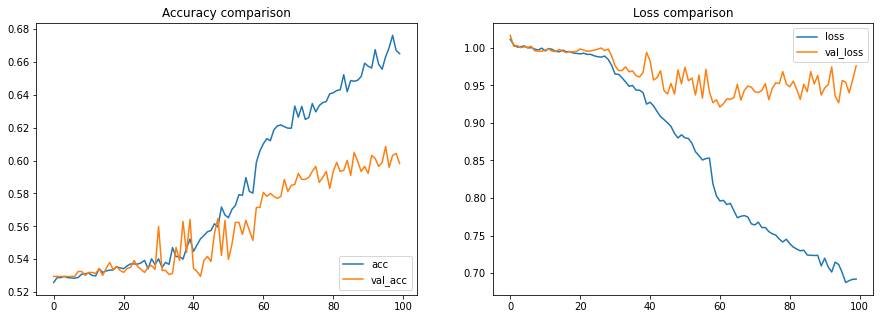

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(general.history['accuracy'], label='acc')
plt.plot(general.history['val_accuracy'], label='val_acc')
plt.legend(loc='lower right')
plt.title('Accuracy comparison')

plt.subplot(1, 2, 2)
plt.plot(general.history['loss'], label='loss')
plt.plot(general.history['val_loss'], label='val_loss')
plt.legend(loc='upper right')
plt.title('Loss comparison')

plt.show()

In [7]:
nonCNN = keras.models.load_model('./result/CNNnon_1201.h5')

In [8]:
y_test = np.array(y_test).astype(np.float32)
nonCNN.evaluate(X_test, y_test)

16/16 [==============================] - 7s 12ms/step - loss: 0.9499 - accuracy: 0.5703


[0.949932336807251, 0.5703125]

In [9]:
import torch
y_test2 = torch.Tensor(y_test)
y_test2 = torch.argmax(y_test2, dim=1)

In [10]:
y_pred_enc = nonCNN.predict(X_test)          # one-hot encoding된 label 예측값
y_pred = [np.argmax(i) for i in y_pred_enc] # label 예측값
matrix = confusion_matrix(y_test2, y_pred)
item = {
      0: 'Type 1'
    , 1: 'Type 2'
    , 2: 'Type 3'
}
res = pd.DataFrame(matrix)
res.columns = item.values()
res.index = item.values()
res

16/16 [==============================] - 0s 10ms/step


,Type 1,Type 2,Type 3
Type 1,23,57,7
Type 2,13,231,21
Type 3,6,116,38


In [12]:
report = classification_report(y_test2, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.55      0.26      0.36        87
           1       0.57      0.87      0.69       265
           2       0.58      0.24      0.34       160

    accuracy                           0.57       512
   macro avg       0.57      0.46      0.46       512
weighted avg       0.57      0.57      0.52       512



## Aug ver CNN

In [ ]:
reduceLR = ReduceLROnPlateau(monitor='val_accuracy', patience=10, verbose= 1, mode='max', factor=  0.2, min_lr = 1e-5)

early_stopping = EarlyStopping(monitor='val_accuracy', patience = 20, verbose=1, mode='max', restore_best_weights= True)

checkpoint_ag = ModelCheckpoint('cnn_v2_ag.weights.hdf5', monitor='val_accuracy', verbose=1,save_best_only=True, mode= 'max')

In [ ]:
gencnn = Sequential([
    Conv2D(64, kernel_size = (3,3), padding='same', kernel_initializer='random_normal', input_shape=(128,128,3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(32, kernel_size = (3,3), padding='same', kernel_initializer='random_normal'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(64, kernel_size = (3,3), padding='same', kernel_initializer='random_normal'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(64, kernel_initializer='random_normal'),
    Activation('relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
    
])

gencnn.compile(
  optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

In [ ]:
ag = gencnn.fit(train_gen, validation_data= valid_ngen, epochs= 100, verbose=1,  steps_per_epoch = TRAIN_STEPS,  callbacks = [reduceLR,checkpoint_ag])
gencnn.save('CNNag_1201.h5')

Epoch 1/100
410/410 [==============================] - 24s 58ms/step - loss: 1.0116 - accuracy: 0.5208 - val_loss: 1.0026 - val_accuracy: 0.5295

Epoch 00001: val_accuracy improved from -inf to 0.52952, saving model to cnn_v2_ag.weights.hdf5
Epoch 2/100
410/410 [==============================] - 24s 60ms/step - loss: 1.0033 - accuracy: 0.5295 - val_loss: 1.0022 - val_accuracy: 0.5295

Epoch 00002: val_accuracy did not improve from 0.52952
Epoch 3/100
410/410 [==============================] - 25s 61ms/step - loss: 1.0036 - accuracy: 0.5295 - val_loss: 1.0021 - val_accuracy: 0.5295

Epoch 00003: val_accuracy did not improve from 0.52952
Epoch 4/100
410/410 [==============================] - 24s 59ms/step - loss: 1.0029 - accuracy: 0.5298 - val_loss: 0.9981 - val_accuracy: 0.5307

Epoch 00004: val_accuracy improved from 0.52952 to 0.53074, saving model to cnn_v2_ag.weights.hdf5
Epoch 5/100
410/410 [==============================] - 25s 61ms/step - loss: 1.0031 - accuracy: 0.5287 - val_lo

In [ ]:
ag.history

{'loss': [1.0115615129470825,
  1.0032696723937988,
  1.003637671470642,
  1.0028765201568604,
  1.0031225681304932,
  1.0024030208587646,
  1.0004891157150269,
  1.0039974451065063,
  1.0007433891296387,
  1.002342939376831,
  0.9979268908500671,
  0.9866647124290466,
  0.9994450807571411,
  0.9999018907546997,
  0.9986682534217834,
  0.9978002309799194,
  0.9977242946624756,
  0.9977285861968994,
  0.9998277425765991,
  0.9974554181098938,
  0.9980236887931824,
  0.9994927048683167,
  0.995585024356842,
  0.9963657855987549,
  0.995099663734436,
  0.9961327910423279,
  0.9965278506278992,
  0.9977933764457703,
  0.9951925873756409,
  0.9957943558692932,
  0.9931741952896118,
  0.9936515688896179,
  0.9935460090637207,
  0.9948248863220215,
  0.9922469854354858,
  0.9931366443634033,
  0.993965744972229,
  0.9928740859031677,
  0.9943144917488098,
  0.9917316436767578,
  0.9924034476280212,
  0.9922462105751038,
  0.9925670623779297,
  0.9922924637794495,
  0.988139808177948,
  0.9922

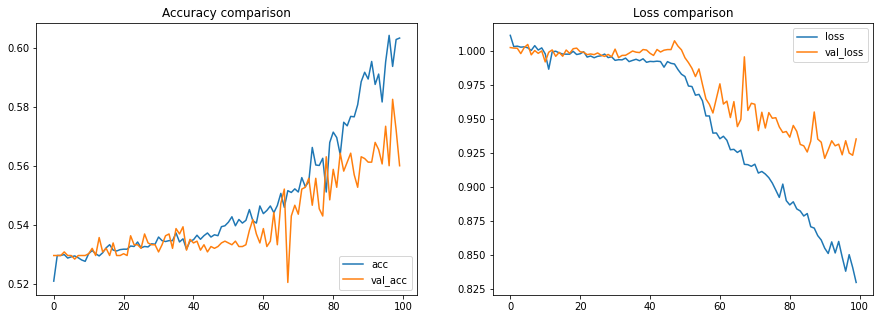

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(ag.history['accuracy'], label='acc')
plt.plot(ag.history['val_accuracy'], label='val_acc')
plt.legend(loc='lower right')
plt.title('Accuracy comparison')

plt.subplot(1, 2, 2)
plt.plot(ag.history['loss'], label='loss')
plt.plot(ag.history['val_loss'], label='val_loss')
plt.legend(loc='upper right')
plt.title('Loss comparison')

plt.show()

In [ ]:
import pickle
with open('CNNag_1201.pkl', 'wb') as f:
	pickle.dump(ag.history, f, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
genCNN = keras.models.load_model('./result/CNNag_1201.h5')

In [14]:
genCNN.evaluate(X_test, y_test)

16/16 [==============================] - 0s 13ms/step - loss: 0.8814 - accuracy: 0.5645


[0.8813976645469666, 0.564453125]

In [16]:
y_pred_enc = genCNN.predict(X_test)          # one-hot encoding된 label 예측값
y_pred = [np.argmax(i) for i in y_pred_enc] # label 예측값
matrix = confusion_matrix(y_test2, y_pred)
item = {
      0: 'Type 1'
    , 1: 'Type 2'
    , 2: 'Type 3'
}
res = pd.DataFrame(matrix)
res.columns = item.values()
res.index = item.values()
res

16/16 [==============================] - 0s 10ms/step


,Type 1,Type 2,Type 3
Type 1,21,59,7
Type 2,16,220,29
Type 3,4,108,48


In [18]:
report = classification_report(y_test2, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.51      0.24      0.33        87
           1       0.57      0.83      0.67       265
           2       0.57      0.30      0.39       160

    accuracy                           0.56       512
   macro avg       0.55      0.46      0.47       512
weighted avg       0.56      0.56      0.53       512



## 전체그래프

In [19]:
import pickle

with open('./result/CNNnon_1201.pkl', 'rb') as f:
	non = pickle.load(f)
with open('./result/CNNag_1201.pkl', 'rb') as f:
	ag = pickle.load(f)

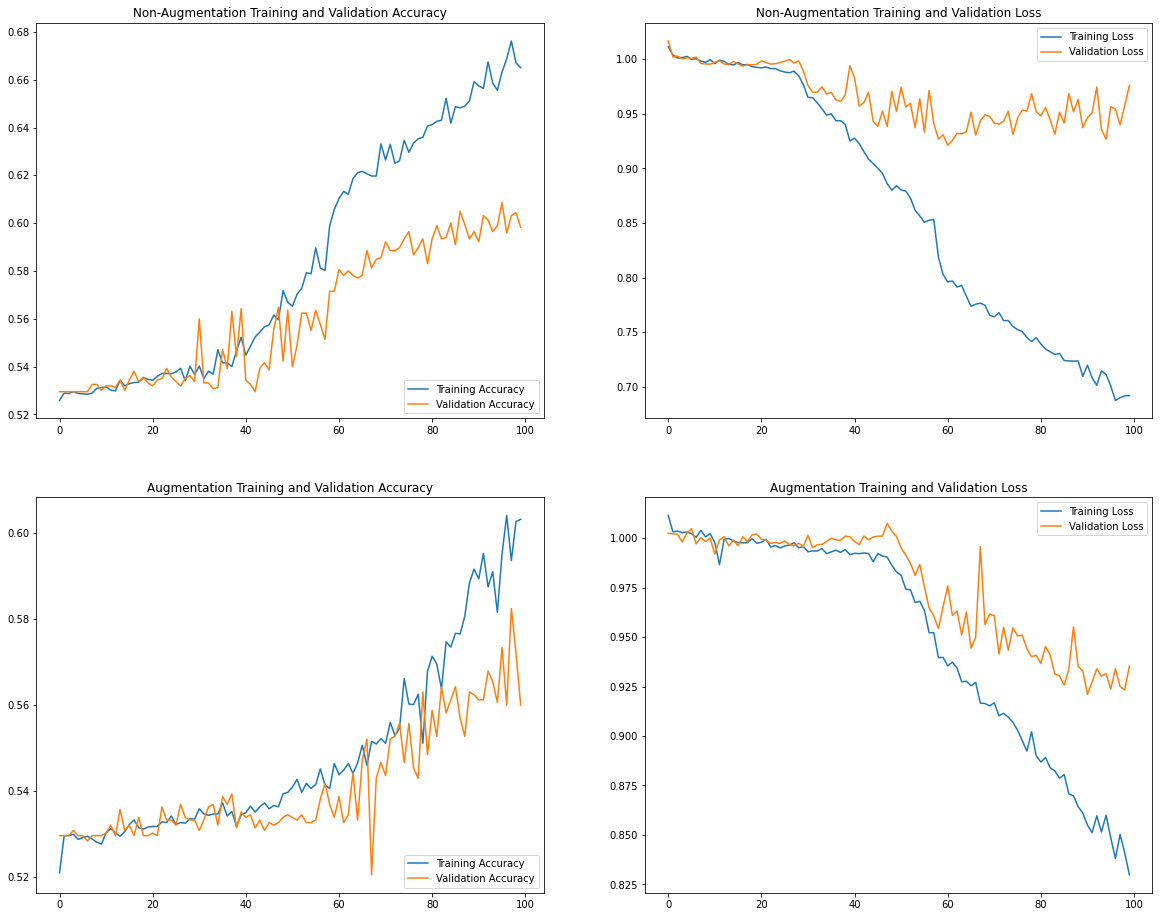

In [20]:
plt.figure(figsize=(20, 16))

plt.subplot(2, 2, 1)
plt.plot(non['accuracy'], label='Training Accuracy')
plt.plot(non['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Non-Augmentation Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(non['loss'], label='Training Loss')
plt.plot(non['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Non-Augmentation Training and Validation Loss')

plt.subplot(2, 2, 3)
plt.plot(ag['accuracy'], label='Training Accuracy')
plt.plot(ag['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Augmentation Training and Validation Accuracy')

plt.subplot(2, 2, 4)
plt.plot(ag['loss'], label='Training Loss')
plt.plot(ag['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Augmentation Training and Validation Loss')

plt.show()